In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

## MODEL PARAMETERS

In [ ]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 4
    LR = 0.001
    VOCAB_SIZE = 1000
    EMBED_DIM = 64
    NUM_HEAD = 4
    FF_DIM = 64
    NUM_LAYERS = 2
config = Config()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


DATA LOADING

Link to Dataset : https://drive.google.com/drive/folders/1cFhVBO-yZdzf-LkAC8ZyRgaHbQO5ukie?usp=sharing

**IMDB Dataset**: Subset of https://ai.stanford.edu/~amaas/data/sentiment/

Task:Fine tuning our own Custom BERT for Mask Language Modelling Task

In [ ]:
def get_text(files):
    txt_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                txt_list.append(line)
    return txt_list


def get_data(folder_name):

    pos_files = glob.glob("/content/gdrive/MyDrive/imdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text(pos_files)
    neg_files = glob.glob("/content/gdrive/MyDrive/imdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df


train_df = get_data("train")
test_df = get_data("test")

all_data = train_df.append(test_df)


<ipython-input-4-8f5266800869>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train_df.append(test_df)


In [ ]:
all_data

,review,sentiment
0,Making the film as dark and visually fuzzy as ...,0
1,This was a disappointing movie. Considering th...,1
2,"When i got this movie free from my job, along ...",0
3,To be brutally honest... I LOVED watching Seve...,1
4,I don't remember seeing another murder/mystery...,1
...,...,...
195,There's nothing to say except I want my time b...,1
196,Not only do I think this was the best film of ...,0
197,My mom brought me this movie on a DVD. A guy i...,1
198,It starts out like a very serious social comme...,1


### Pre-processesing text data
 In this pre-training approach, some input tokens are masked with the [MASK] token. Then the model is trained to predict the masked Tokens by gathering the context from the surrounding Tokens.
 Used 15% as the paper around Masked Language modelling tend to give better result with it.

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )


def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):

    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert mask token in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer


vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Get mask token id for masked language model
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]


def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()


def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default,
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] e 90% of tokens
    #  10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Testing/Sampling
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights


# We have 300 examples for training
x_train = encode(train_df.review.values)  # encode reviews with vectorizer
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# We have 100 examples for testing
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)


test_raw_classifier_ds = tf.data.Dataset.from_tensor_slices(
    (test_df.review.values, y_test)
).batch(config.BATCH_SIZE)

# Prepare data for mlm
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

### BERT MODULE CONSTRUCTION WITH VANILLA TRANSFORMER AND ATTENTION MECHANISM

In [ ]:
def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")


class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)


        return {"loss": loss_tracker.result()}


    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()
bert_masked_model.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 word_embedding (Embedding)  (None, 128, 64)              64000     ['input_8[0][0]']             
                                                                                                  
 tf.math.add_7 (TFOpLambda)  (None, 128, 64)              0         ['word_embedding[0][0]']      
                                                                                                  
 encoder_0/multiheadattenti  (None, 128, 64)              16640     ['tf.math.add_7[0][0]',       
 on (MultiHeadAttention)                                             'tf.math.add_

In [ ]:
bert_masked_model.fit(mlm_ds, epochs=5, callbacks=[generator_callback])
bert_masked_model.save("bert_mlm_imdb.h5")

TypeError: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128)]             0         
                                                                 
 model_4 (Functional)        (None, 128, 64)           89216     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 93441 (365.00 KB)
Trainable params: 4225 (16.50 KB)
Non-trainable params: 89216 (348.50 KB)
____________

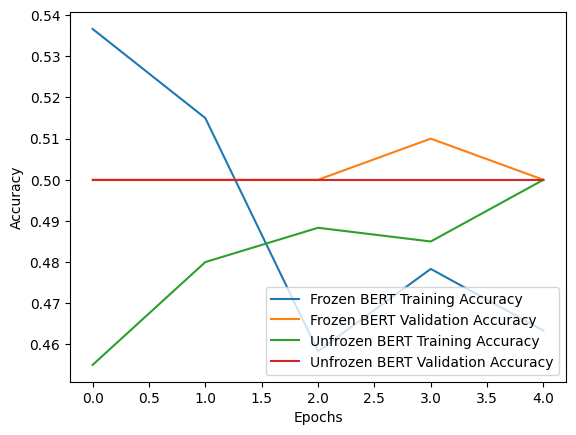

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier
history_frozen = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)


#  fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

history_unfrozen = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

In [ ]:
# Plot the loss and accuracy of the frozen model
plt.figure(0)
plt.plot(history_frozen.history["loss"], label="loss")
plt.plot(history_frozen.history["val_loss"], label="val_loss")
plt.plot(history_frozen.history["accuracy"], label="accuracy")
plt.plot(history_frozen.history["val_accuracy"], label="val_accuracy")
plt.title("Frozen Model Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

# Plot the loss and accuracy of the unfrozen model
plt.figure(1)
plt.plot(history_unfrozen.history["loss"], label="loss")
plt.plot(history_unfrozen.history["val_loss"], label="val_loss")
plt.plot(history_unfrozen.history["accuracy"], label="accuracy")
plt.plot(history_unfrozen.history["val_accuracy"], label="val_accuracy")
plt.title("Unfrozen Model Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

plt.show()

### ROTARY EMBEDDINGS

TRAINING BERT WITH ROTARY EMBEDDINGS
Link:https://arxiv.org/pdf/2104.09864.pdf

In [ ]:
import tensorflow as tf
from keras.layers import Layer
def rot_half(x):
    x_shape = tf.shape(x)
    const = tf.constant([2], tf.int32)
    new_shape = tf.concat([ x_shape[:-1], tf.cast(x_shape[-1, None] / const, tf.int32), const ], axis = 0)
    x = tf.reshape(x, new_shape)
    x1, x2 = tf.split(x, 2, axis = -1)
    x1, x2 = tf.squeeze(x1, axis = -1), tf.squeeze(x2, axis = -1)
    x = tf.stack([ -x2, x1 ], axis = -1)
    return tf.reshape(x, x_shape)

def apply_rot(freqs, x, scale = 1.0):
    freqs = tf.cast(freqs, x.dtype)
    scale = tf.cast(scale, x.dtype)
    rotary_dim = freqs.shape[-1]
    x_left, x, x_right = x[..., :0], x[..., 0:rotary_dim], x[..., rotary_dim:]
    x = (x * tf.math.cos(freqs) * scale) + (rot_half(x) * tf.math.sin(freqs) * scale)
    return tf.concat([ x_left, x, x_right ], axis = -1)

class RoPE(Layer):
    def __init__(self,
                 dim : int,
                 theta : int = 10000,
                 xpos_scale_base : int = 512,
                 interpolate_factor : float = 1.0,
                 theta_rescale_factor : float = 1.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.theta = theta
        self.xpos_scale_base = xpos_scale_base
        self.interpolate_factor = interpolate_factor
        self.theta_rescale_factor = theta_rescale_factor

        theta *= theta_rescale_factor ** (dim / (dim - 2))
        self.freqs = 1.0 / (theta ** (tf.range(0, dim, 2)[:(dim // 2)] / dim))
        self.interpolate_factor = interpolate_factor

        self.scale = (tf.range(0, dim, 2, self.freqs.dtype) + .4 * dim) / (1.4 * dim)
        self.scale_base = xpos_scale_base

        self.built = True

    def _calc_freqs(self, x):
        n = x.shape[-2]
        seq_pos = tf.range(n, dtype = self.freqs.dtype) / self.interpolate_factor
        freqs = tf.einsum('..., f-> ...f', seq_pos, self.freqs)
        freqs = tf.repeat(freqs, 2, axis = -1)
        return freqs, seq_pos

    def rotate(self, x):
        if isinstance(x, list):
            q, k = x
            n = q.shape[-1]
            freqs, seq_pos = self._calc_freqs(q)
            power = (seq_pos - n // 2) / self.scale_base
            scale = self.scale ** tf.transpose(power[tf.newaxis])
            scale =  tf.concat([ scale, scale ], axis = -1)
            q = apply_rot(freqs, q, scale = scale)
            k = apply_rot(freqs, k, scale = scale ** -1)
            return q, k

        freqs, _ = self._calc_freqs(x)
        return apply_rot(freqs, x)

In [ ]:
rotary_emb = RoPE(dim = 16)

In [ ]:
def bert_module_rope(query, key, value, i):
    # Multi headed self-attention
    query=rotary_emb.rotate(query)
    key=rotary_emb.rotate(key)
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")


class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module_rope(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model_rope = create_masked_language_bert_model()
bert_masked_model_rope.summary()

Model: "masked_bert_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 word_embedding (Embedding)  (None, 128, 64)              64000     ['input_7[0][0]']             
                                                                                                  
 tf.math.add_6 (TFOpLambda)  (None, 128, 64)              0         ['word_embedding[0][0]']      
                                                                                                  
 tf.__operators__.getitem_6  (None, 128, 16)              0         ['tf.math.add_6[0][0]']       
 1 (SlicingOpLambda)                                                              

In [ ]:
bert_masked_model_rope.fit(mlm_ds, epochs=2, callbacks=[generator_callback])
bert_masked_model_rope.save("bert_mlm_rope_imdb.h5")

TypeError: ignored

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128)]             0         
                                                                 
 model_5 (Functional)        (None, 128, 64)           89216     
                                                                 
 global_max_pooling1d_5 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 93441 (365.00 KB)
Trainable params: 4225 (16.50 KB)
Non-trainable params: 89216 (348.50 KB)
____________

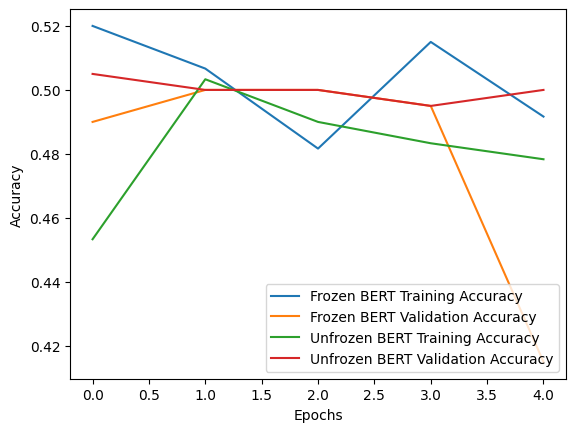

In [ ]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_rope_imdb.h5", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False


def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return classifer_model


classifer_model = create_classifier_bert_model()
classifer_model.summary()

# Train the classifier
history_frozen = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)


# fine-tuning
pretrained_bert_model.trainable = True
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

history_unfrozen = classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)


plt.plot(history_frozen.history['accuracy'], label='Frozen BERT witn RoPE Training Accuracy')
plt.plot(history_frozen.history['val_accuracy'], label='Frozen BERT witn RoPE Validation Accuracy')
plt.plot(history_unfrozen.history['accuracy'], label='Unfrozen BERT witn RoPE Training Accuracy')
plt.plot(history_unfrozen.history['val_accuracy'], label='Unfrozen BERT witn RoPE Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
